# Sentinel Hub Batch Processing

A tutorial about [Large area utilities](./large_area_utilities.ipynb) shows how to split a large area into smaller bounding boxes for which data can be requested using [Sentinel Hub Process API](./process_request.ipynb). This tutorial shows another way of doing that.

**Sentinel Hub Batch Processing** takes the geometry of a large area and divides it according to a specified tile grid. Next, it executes processing requests for each tile in the grid and stores results to a given location at AWS S3 storage. All this is efficiently executed on the server-side. Because of the optimized performance, it is significantly faster than running the same process locally. 

More information about batch processing is available at Sentinel Hub documentation pages:

- [How Batch API works](https://docs.sentinel-hub.com/api/latest/api/batch/)
- [Batch API service description](https://docs.sentinel-hub.com/api/latest/reference/#tag/batch_process)


The tutorial will show a standard process of using Batch Processing with `sentinelhub-py`. The process can be divided into:

1. Define and create a batch request
2. Analyse a batch request before it is executed
3. Run a batch requests job and check the outcome

**Imports**

The tutorial requires packages `geopandas` and `descartes` which are not dependencies of `sentinelhub-py`.

In [134]:
%matplotlib inline

import datetime as dt
import os

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from sentinelhub import (
    CRS,
    DataCollection,
    Geometry,
    MimeType,
    SentinelHubBatch,
    SentinelHubRequest,
    SHConfig,
    bbox_to_dimensions,
    monitor_batch_job,
    MosaickingOrder
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

## 1. Create a batch request

To create a batch request we need to do the following:

- Define a Process API request which we would like to execute on a large area.
- Select a tiling grid which will define how our area will be split into smaller tiles.
- Set up an S3 bucket where results will be saved.


### 1.1 Define a Process API request

First, let's set up the credentials the same way as in [Sentinel Hub Process API tutorial](./process_request.ipynb).

In [135]:
config = SHConfig()
config.sh_client_id = 'e3a62bc6-8f7e-43b9-8a01-b16ac86bfe7d'
config.sh_client_secret = 'M5tkaWx1JhEwUYq6LmX7FtKwp8mtwjsu'

if config.sh_client_id == "" or config.sh_client_secret == "":
    print("Warning! To use Sentinel Hub Process API, please provide the credentials (client ID and client secret).")

For our area of interest, we'll take an area of crop fields in California.

<AxesSubplot:>

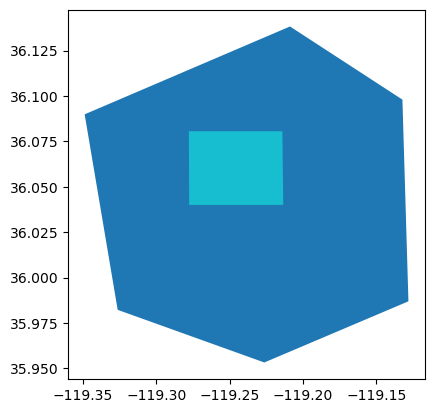

In [136]:
SHAPE_PATH = os.path.join(".", "data", "california_crop_fields.geojson")
area_gdf = gpd.read_file(SHAPE_PATH)

# Geometry of an entire area
full_geometry = Geometry(area_gdf.geometry.values[0], crs=CRS.WGS84)
# Bounding box of a test sub-area
test_bbox = Geometry(area_gdf.geometry.values[1], crs=CRS.WGS84).bbox

area_gdf.plot(column="name")

Let's check a true-color satellite image of the entire area:

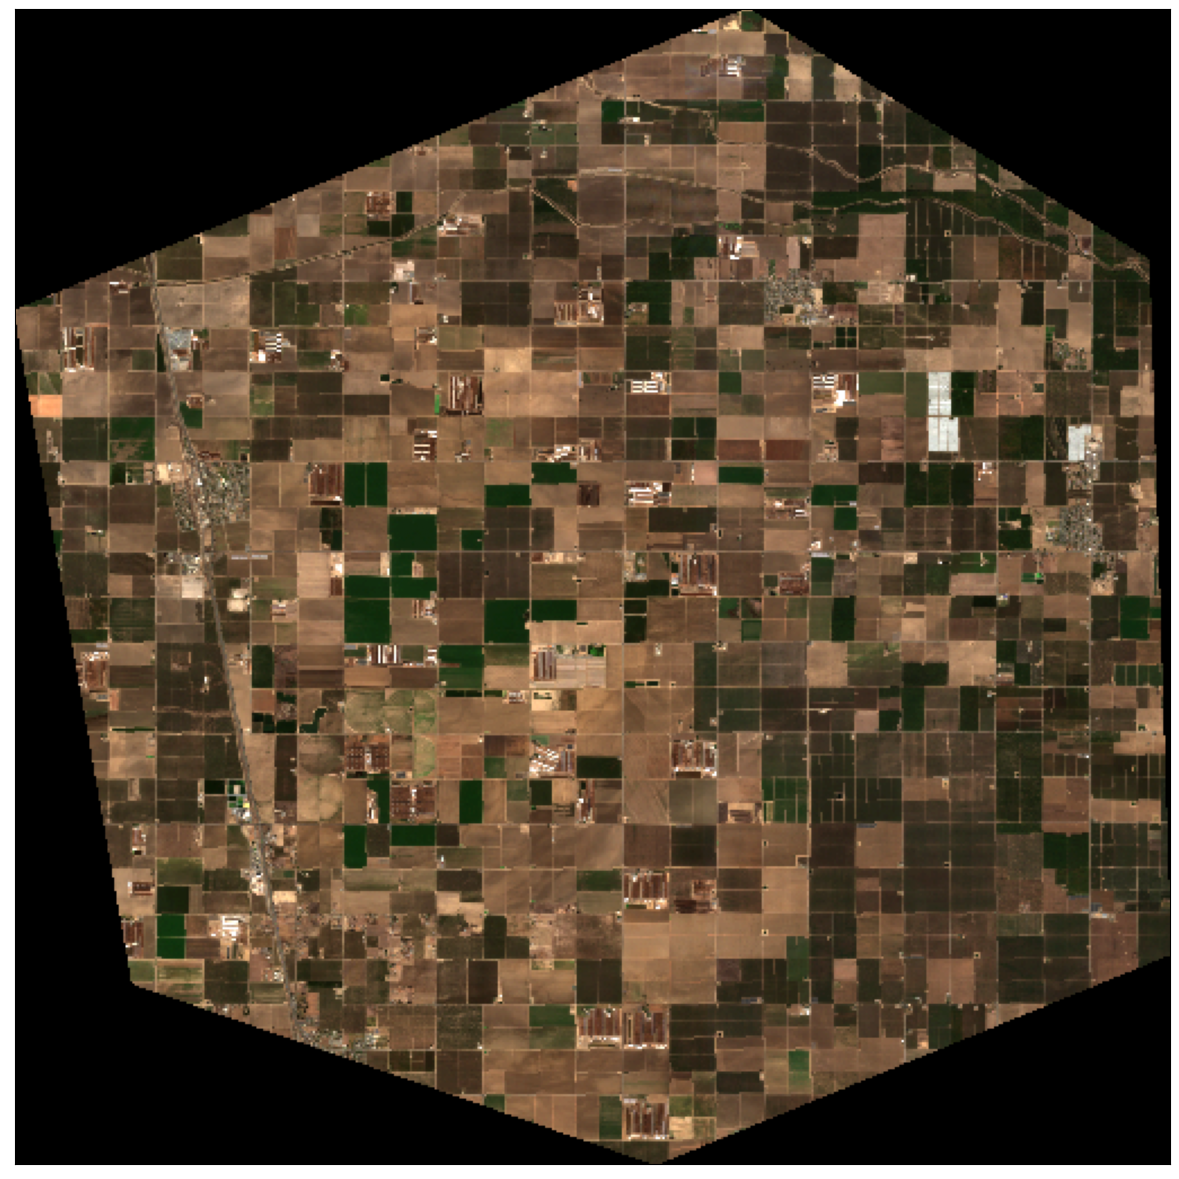

In [151]:
evalscript_true_color = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }
    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=("2023-11-01", "2023-11-30"),
            mosaicking_order=MosaickingOrder.LEAST_CC
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    geometry=full_geometry,
    size=(512, 512),
    config=config,
)

image = request.get_data()[0]

plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

Next, let's define an evalscript and time range. To better demonstrate the power of batch processing we'll take an evalscript that returns a temporally-interpolated stack NDVI values.

<div class="alert alert-warning">

<b>Warning:</b>
    
In the following cell parameters `evalscript` and `time_interval` are both defined for the same time interval. If you decide to change the time interval you have to change it both in the cell and in the evalscript code.
</div>

In [138]:
EVALSCRIPT_PATH = os.path.join(".", "data", "interpolation_evalscript.js")

with open(EVALSCRIPT_PATH, "r") as fp:
    evalscript = fp.read()

time_interval = dt.date(year=2020, month=7, day=1), dt.date(year=2020, month=7, day=30)

Now we can define a Process API request and test it on a smaller sub-area to make sure we get back desired data.

Output data: ['NDVI.tif', 'data_mask.tif']
CPU times: user 82 ms, sys: 7.45 ms, total: 89.4 ms
Wall time: 10.3 s


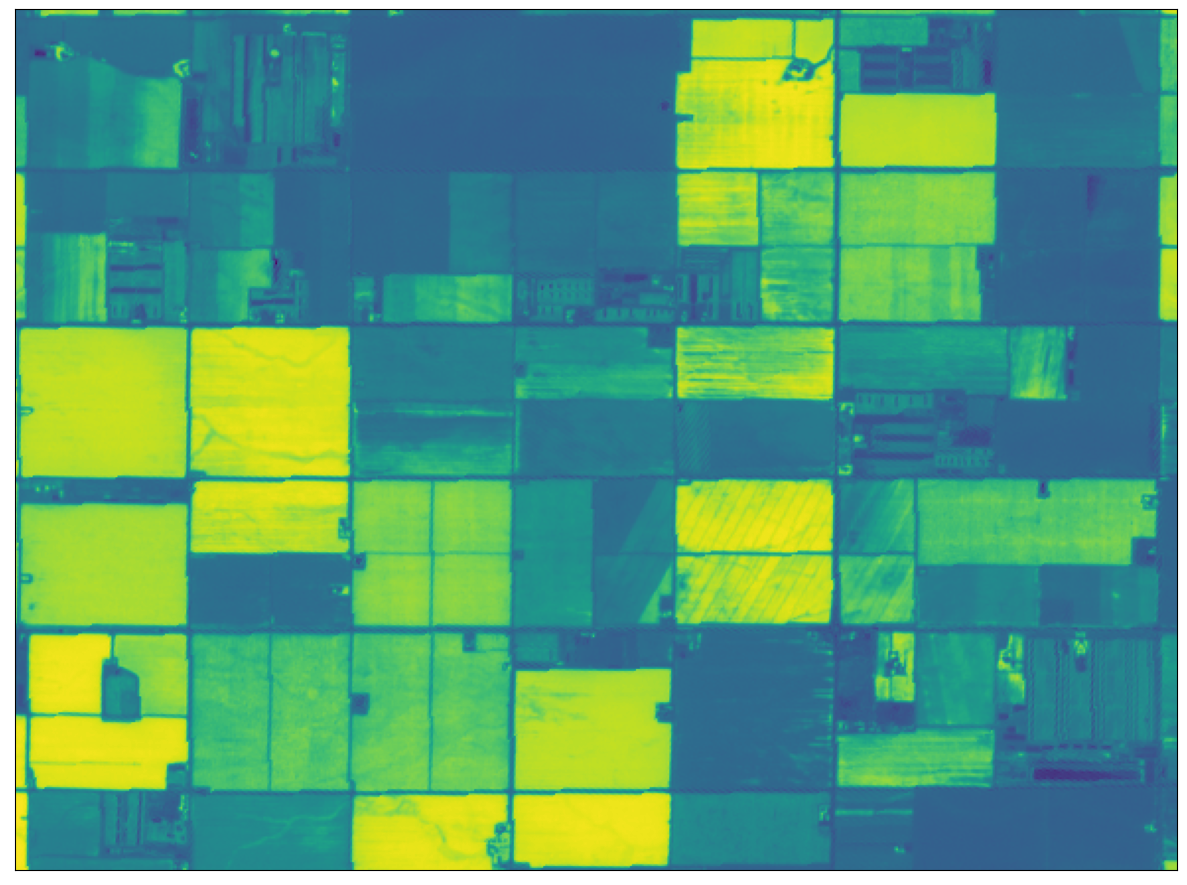

In [139]:
%%time

sentinelhub_request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=time_interval,
        )
    ],
    responses=[
        SentinelHubRequest.output_response("NDVI", MimeType.TIFF),
        SentinelHubRequest.output_response("data_mask", MimeType.TIFF),
    ],
    bbox=test_bbox,
    size=bbox_to_dimensions(test_bbox, 10),
    config=config,
)

results = sentinelhub_request.get_data()[0]

print(f"Output data: {list(results)}")

plot_image(results["NDVI.tif"][..., 2])

We obtained stacks of NDVI values and data masks. 

### 1.2 Define a batch client

The interface for Sentinel Hub Batch API is class `SentinelHubBatch`. We initialize it with a configuration object that contains credentials and URLs of the services.

<div class="alert alert-info">

<b>Note:</b>
    
The `SentinelHubBatch` interface was changed in `sentinelhub` package version `3.4.0`. This tutorial is using the latest version.
</div>

In [140]:
batch = SentinelHubBatch(config=config)

Alternatively, to run interact with Batch API on different Sentinel Hub deployments we could pass a configuration object with different parameters.

In [141]:
uswest_config = SHConfig()
uswest_config.sh_base_url = "https://services-uswest2.sentinel-hub.com"

uswest_batch = SentinelHubBatch(config=uswest_config)

### 1.3 Select a tiling grid

Batch API offers a number of pre-defined tiling grids. We can check which ones are available.

In [142]:
list(batch.iter_tiling_grids())

[{'id': 0,
  'name': '20km grid',
  'properties': {'tileWidth': 20040.0,
   'tileHeight': 20040.0,
   'chunkWidth': 334,
   'chunkHeight': 167,
   'resolutions': [10.0, 20.0, 60.0],
   'singleCrs': False,
   'unit': 'METRE'}},
 {'id': 1,
  'name': '10km grid',
  'properties': {'tileWidth': 10000.0,
   'tileHeight': 10000.0,
   'chunkWidth': 500,
   'chunkHeight': 500,
   'resolutions': [1.0, 10.0, 20.0, 1.4999],
   'singleCrs': False,
   'unit': 'METRE'}},
 {'id': 2,
  'name': '100km grid',
  'properties': {'tileWidth': 100080.0,
   'tileHeight': 100080.0,
   'chunkWidth': 278,
   'chunkHeight': 278,
   'resolutions': [360.0, 60.0, 120.0, 240.0],
   'singleCrs': False,
   'unit': 'METRE'}},
 {'id': 3,
  'name': 'WGS84 1 degree grid',
  'properties': {'tileWidth': 1.0,
   'tileHeight': 1.0,
   'chunkWidth': 500,
   'chunkHeight': 500,
   'resolutions': [0.0005, 0.001, 0.002, 0.005, 0.008, 0.0001, 0.0002, 0.0008],
   'singleCrs': True,
   'unit': 'DEGREE'}},
 {'id': 6,
  'name': 'LAEA 10

Let's select a 10km grid, which is based on Sentinel-2 data tiling grid in UTM coordinate reference systems.

There is also an option to check a definition for a single grid:

In [143]:
# Specify grid ID here:
GRID_ID = 1

batch.get_tiling_grid(GRID_ID)

{'id': 1,
 'name': '10km grid',
 'properties': {'tileWidth': 10000.0,
  'tileHeight': 10000.0,
  'chunkWidth': 500,
  'chunkHeight': 500,
  'resolutions': [1.0, 10.0, 20.0, 1.4999],
  'singleCrs': False,
  'unit': 'METRE'}}

### 1.4 Set up an S3 bucket

For this step please follow [instructions](https://docs.sentinel-hub.com/api/latest/api/batch/#aws-s3-bucket-settings) on how to configure an S3 bucket in a way that Sentinel Hub service will be able to write to it.

In [144]:
# Write bucket name here:
BUCKET_NAME = ""

### 1.5 Join batch request definition

Now we are ready to create an entire batch request. This step won't trigger the actual processing. It will only save a batch request definition to the server-side.

In [145]:
sentinelhub_request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=time_interval,
        )
    ],
    responses=[
        SentinelHubRequest.output_response("NDVI", MimeType.TIFF),
        SentinelHubRequest.output_response("data_mask", MimeType.TIFF),
    ],
    geometry=full_geometry,
    # This time we don't specify size parameter
    config=config,
)

batch_request = batch.create(
    sentinelhub_request,
    tiling_grid=SentinelHubBatch.tiling_grid(grid_id=GRID_ID, resolution=10, buffer=(50, 50)),
    bucket_name=BUCKET_NAME,
    # Check documentation for more about output configuration options:
    # output=SentinelHubBatch.output(...)
    description="sentinelhub-py tutorial batch job",
)

batch_request

DownloadFailedException: Failed to download from:
https://services.sentinel-hub.com/api/v1/batch/process
with HTTPError:
403 Client Error: Forbidden for url: https://services.sentinel-hub.com/api/v1/batch/process
Server response: "{"status": 403, "reason": "Forbidden", "message": "You are not authorized to perform this action.", "code": "COMMON_INSUFFICIENT_PERMISSIONS"}"

A batch request has been successfully created. The information about a request is provided in the form of a `BatchRequest` dataclass object. From the object representation, we can see some of its main properties, such as `status`, which defines the current status of a batch request. 

We can also check its full payload:

In [ ]:
batch_request.to_dict()

Any information about a batch request can be obtained from its info dictionary. There are a few properties available to help with extraction:

In [ ]:
print(batch_request.evalscript == evalscript)
print(batch_request.geometry == full_geometry)

At this point you can write down your batch request ID. In case you restart your Python kernel or delete `batch_request` object you can always re-initialize it with the request ID:

In [ ]:
# Write your batch_request.request_id here
REQUEST_ID = ""

batch_request_1 = batch.get_request(REQUEST_ID)

batch_request_1

## 2. Analyse a batch request

Before we run a batch request job we can check currently defined batch requests and run an analysis to determine the outcome of a batch request. Important information we can obtain from this step are:

- the exact geometries of tiles from a tiling grid that will be processed,
- the number of processing units that a batch job will cost.

Note that this analysis paragraph is optional and is not required to run a batch request job.

### 2.1 Investigate past batch requests

We already have our current batch request definition in `batch_request` variable. However, if we would like to find it again we can search the history of all created batch requests:

In [ ]:
for request in batch.iter_requests():
    print(request)

Alternatively, we can use a method that provides the latest created batch request:

In [ ]:
batch_request = batch.get_latest_request()

batch_request

### 2.2 Run an analysis

At the moment we don't have information about tiles or processing units yet. But we can order the service to calculate it.

The following will start the analysis on the server-side:

In [ ]:
batch.start_analysis(batch_request)

Depending on the size of our batch request it might take from a few seconds to a few minutes for analysis to finish. To determine if the analysis has finished we have to update batch request info and check the `status` information:

In [ ]:
batch_request = batch.get_request(batch_request)

batch_request

Once analysis is completed the `valueEstimate` tells us an estimated number of processing units the batch job will cost.

In [ ]:
print(f"Running this batch job will take about {batch_request.value_estimate:.4f} processing units")

### 2.3 Check tile definitions

When the analysis is complete we can check information about tiles:

In [ ]:
for tile_info in batch.iter_tiles(batch_request):
    print(tile_info)

Optionally, we can request information about a single tile:

In [ ]:
# Specify a tile ID
TILE_ID = ""

batch.get_tile(batch_request, TILE_ID)

To interact with tiles we can also use a type of an `AreaSplitter` class which already parses geometries:

In [ ]:
from sentinelhub import BatchSplitter

splitter = BatchSplitter(batch_request=batch_request, config=config)
splitter.get_bbox_list()

Let's plot the geometries:

In [ ]:
def plot_batch_splitter(splitter):
    """Plots tiles and area geometry from a splitter class"""
    tile_geometries = [Geometry(bbox.geometry, bbox.crs) for bbox in splitter.get_bbox_list()]
    tile_geometries = [geometry.transform(splitter.crs) for geometry in tile_geometries]

    gdf = gpd.GeoDataFrame(
        {"status": [info["status"] for info in splitter.get_info_list()]},
        geometry=[geometry.geometry for geometry in tile_geometries],
        crs=splitter.crs.pyproj_crs(),
    )
    gdf = gdf.dissolve(by="status").reset_index()
    color_map = {
        "PROCESSED": "tab:green",
        "FAILED": "tab:red",
        "PENDING": "tab:blue",
        "SCHEDULED": "tab:cyan",
    }

    _, ax = plt.subplots(figsize=(10, 10))
    pmarks = []

    for status, sdf in gdf.groupby("status"):
        sdf.plot(ax=ax, color=color_map[status], label=status)
        pmarks.append(Patch(facecolor=color_map[status], label=status))

    area_series = gpd.GeoSeries([splitter.get_area_shape()], crs=splitter.crs.pyproj_crs())
    area_series.plot(ax=ax, facecolor="none", edgecolor="black")

    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles=[*handles, *pmarks], loc="lower right")


plot_batch_splitter(splitter)

## 3. Run a batch request job

Once we decide to run a batch request job we can trigger it with the following:

In [ ]:
batch.start_job(batch_request)

Again we can check if a job has finished by updating batch request info.

In [ ]:
batch_request = batch.get_request(batch_request)

batch_request

This package also provides a utility function that monitors batch job execution by periodically checking for status of all tiles and sleeping in between.

In [ ]:
monitor_batch_job(batch_request, config=config, sleep_time=60)  # It will update progress every 60 seconds

Another option is to check which results have already been saved to the given S3 bucket.

When the job is running we can decide at any time to cancel it. Results that have already been produced will remain on the bucket.

In [ ]:
batch.cancel_job(batch_request)

When a job has finished we can check the status in batch request info and statuses of each tile:

In [ ]:
splitter = BatchSplitter(batch_request=batch_request, config=config)

plot_batch_splitter(splitter)

In case processing for any tile fails we have an option to re-run the job again. This will only run the processing for the tiles that failed.

In [ ]:
batch.restart_job(batch_request)

Alternatively, we can re-run processing only for a single tile:

In [ ]:
# Specify an ID of a tile that failed
FAILED_TILE_ID = ""

batch.reprocess_tile(batch_request, FAILED_TILE_ID)